In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
zip_path = '/content/drive/MyDrive/InnHackathon24/movie_data.zip'

import zipfile

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup

In [4]:
# Read CSV files
movies = pd.read_csv('/content/movies.csv')
ratings = pd.read_csv('/content/ratings.csv')
tags = pd.read_csv('/content/tags.csv')
links = pd.read_csv('/content/links.csv')

In [5]:
# shape of movies.csv
movies.shape

(9742, 3)

In [6]:
# shape of ratings.csv
ratings.shape

(100836, 4)

In [7]:
# No. of Unique "userId" available in "ratings.csv"
ratings.userId.nunique()

610

In [8]:
# movie that had received maximum number of user ratings as per count
movies[movies.movieId == ratings.movieId.value_counts().max()]

,movieId,title,genres
287,329,Star Trek: Generations (1994),Adventure|Drama|Sci-Fi


In [11]:
# movie that had received maximum number of user ratings as per adding the rating value
movies[movies.movieId == ratings.groupby(by='movieId')['rating'].sum().sort_values(ascending=False).head(1).index[0]]

,movieId,title,genres
277,318,"Shawshank Redemption, The (1994)",Crime|Drama


In [12]:
# Tags submitted by users to "Matrix,The (1999)" movie

tags[tags['movieId'] == movies.loc[movies['title'] == "Matrix, The (1999)", 'movieId'].iloc[0]]

,userId,movieId,tag,timestamp
815,424,2571,martial arts,1457842912
816,424,2571,sci-fi,1457842899
1646,474,2571,alternate universe,1137204991
2794,537,2571,philosophy,1424141098
2795,537,2571,post apocalyptic,1424141101


In [13]:
# What is the average user rating for movie named "Terminator 2: Judgment Day (1991)"?
ratings[ratings.movieId == movies.loc[movies['title'] == "Terminator 2: Judgment Day (1991)", 'movieId'].iloc[0]].rating.mean()

3.970982142857143

#### How does the data distribution of user ratings for "Fight Club (1999)" movie looks like?


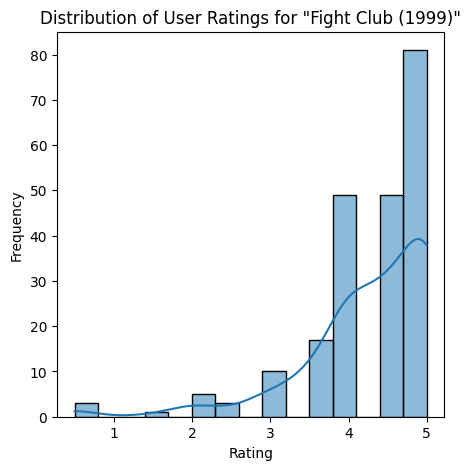

In [14]:
# Movie title
movie_title = 'Fight Club (1999)'

# Filter movies based on title
fight_club = movies[movies['title'] == movie_title]

# Filter ratings based on movieId
ratings_fight_club = ratings[ratings['movieId'].isin(fight_club['movieId'])]

# Plot the histogram
plt.figure(figsize=(5, 5))
sns.histplot(ratings_fight_club['rating'], kde=True, bins=15)
plt.title(f'Distribution of User Ratings for "{movie_title}"')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# clearly plot is left skewed

## Mandatory Operations:


#### 1. Group the user ratings based on movieId and apply aggregation operations like count and mean on ratings.


In [16]:
movie_ratings = ratings.groupby('movieId')['rating'].agg(['mean', 'count']).reset_index()
movie_ratings.columns = ['movieId', 'mean', 'count']

#### 2. Apply inner join on dataframe created from movies.csv and the grouped df from step 1.


In [17]:
movie_data = pd.merge(movies, movie_ratings, on='movieId', how='inner')

#### 3. Filter only those movies which have more than 50 user ratings (i.e. > 50).

In [18]:
popular_movies = movie_data[movie_data['count'] > 50]

In [19]:
# Movie that is most popular based on average user ratings
popular_movies[popular_movies['mean'] == popular_movies['mean'].max()]['title'].unique()

array(['Shawshank Redemption, The (1994)'], dtype=object)

In [21]:
# Top 5 popular movies based on the number of user ratings
popular_movies.nlargest(5, 'count')

,movieId,title,genres,mean,count
314,356,Forrest Gump (1994),Comedy|Drama|Romance|War,4.164134,329
277,318,"Shawshank Redemption, The (1994)",Crime|Drama,4.429022,317
257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.197068,307
510,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,4.161290,279
1938,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.192446,278


In [22]:
# Sci-Fi movie "third most popular" based on the number of user ratings
popular_movies[popular_movies['genres'].str.contains('Sci-Fi')].nlargest(3, 'count')

,movieId,title,genres,mean,count
1938,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.192446,278
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.231076,251
418,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,3.750000,238


#### Using "links.csv", scrape the IMDB reviews of each movie with more than 50 user ratings.

In [23]:
# Web Scraping
def scrapper(imdbId):
    id_str = str(int(imdbId)).zfill(7)
    URL = f"https://www.imdb.com/title/tt{id_str}/"
    request_header = {'Content-Type': 'text/html; charset=UTF-8',
                      'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:109.0) Gecko/20100101 Firefox/119.0',
                      'Accept-Encoding': 'gzip, deflate, br'}
    response = requests.get(URL, headers=request_header)
    soup = BeautifulSoup(response.text, 'html.parser')
    imdb_rating = soup.find('span', attrs={'class': 'ipc-rating-star'})
    return imdb_rating.text if imdb_rating else np.nan

In [27]:
imdbtop50 = pd.merge(left = popular_movies , right = links , on = 'movieId' ,how ='inner')

In [28]:
# Assuming imdb_ids is a list of IMDb IDs obtained from 'links.csv'
imdb_ids = list(imdbtop50['imdbId'])
extracted_ratings = [scrapper(imdb_id) for imdb_id in imdb_ids]

In [30]:
len(extracted_ratings)

436

In [31]:
# Create DataFrame for scraped ratings
scraped_ratings_df = pd.DataFrame({'movieId': popular_movies['movieId'], 'imdbRating': extracted_ratings})

In [32]:
scraped_ratings_df.shape

(436, 2)

In [35]:
# MovieId of the movie which has the highest IMDB rating
scraped_ratings_df.sort_values(by='imdbRating',ascending = False).head(1).iloc[0]

movieId       527
imdbRating    9.3
Name: 461, dtype: object

In [37]:
# MovieId of the "Sci-Fi" movie which has the highest IMDB rating


df_1 = pd.merge(left=popular_movies,right = scraped_ratings_df,how = 'inner',on = 'movieId')

df_1[df_1['genres'].str.contains('Sci-Fi')].sort_values(by='imdbRating',ascending=False).head(1)

,movieId,title,genres,mean,count,imdbRating
248,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.192446,278,8.8
